# Python wrapper to download Venus atmospheric data from The Venus Climate Database (VCD)
- Generates url calls based on http://www-venus.lmd.jussieu.fr/vcd_python/
- Read and parse VCD text outputs and store them as dataframes

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup

In [27]:
url = 'http://www-venus.lmd.jussieu.fr/vcd_python/txt/5484fcb83aa5532f762145f62fb0a582.txt'
response = urllib.request.urlopen(url)
html_content = response.read()

text_file_content = html_content.decode('utf-8').split('\n')

tag_variable = 'Column 2 is'
all_data = dict()
alts = []
first_pass = True
for line in text_file_content:

    if tag_variable in line:
        current_variable = line.split(tag_variable)[1]
        all_data[current_variable] = []
        if len(alts) > 0:
            first_pass = False

        continue

    if '###' in line or '-----' in line:
        continue

    if len(line.split(' ')) == 1:
        continue

    if len(line.split(' ')) > 1:
        vals = [ee for ee in line.split(' ') if ee]
        alt = float(vals[0])
        val = float(vals[1])
        all_data[current_variable].append(val)
        if first_pass:
            alts.append(alt)

pd_all_data = pd.DataFrame(alts, columns=['altitude'])
for unknown, vals in all_data.items():
    pd_all_data[unknown] = vals

In [44]:
def download_data(var1, var2, var3, var4, altitude, year, month, day, hours, lat, lon):

    # Step 1: Specify the URL
    baseline_url = "http://www-venus.lmd.jussieu.fr/vcd_python/cgi-bin/"
    l_vars = f'var1={var1}&'
    if var2 != 'None':
        l_vars += f'var2={var2}&'
    if var3 != 'None':
        l_vars += f'var3={var3}&'
    if var4 != 'None':
        l_vars += f'var4={var4}'
    
    url = f"{baseline_url}vcdcgi.py?{l_vars}&datekeyhtml=1&localtime=0.&year={year}&month={month}&day={day}&hours={hours}&minutes=1&seconds=1&julian=2460229.318483796&ls=177.2&latitude={lat}&longitude={lon}&altitude={altitude}&zkey=3&spacecraft=none&isfixedlt=off&albedo_scena=1&EUV_scena=1&varE107=200.&hrkey=1&averaging=off&dpi=80&islog=off&colorm=jet&minval=&maxval=&proj=cyl&palt=&plon=&plat=&trans=&iswind=off&latpoint=&lonpoint=4"

    # Step 2: Send an HTTP request and retrieve the HTML content
    response = urllib.request.urlopen(url)
    html_content = response.read()

    # Step 3: Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, "html.parser")

    # Extract and print all the <a> tags
    for link in soup.find_all('a'):
        url_output = f"{baseline_url}{link.get('href')}"
        print(url_output)
        response = urllib.request.urlopen(url_output)
        text_file_content = response.read().decode('utf-8').split('\n')
        break
        
    return text_file_content

def load_one_file(text_file_content, tag_variable='Columns 2+ are '):
    
    all_data = pd.DataFrame()
    if 'is' in tag_variable:
        all_data = dict()
        
    alts = []
    first_pass = True 
    for line in text_file_content:

        if tag_variable in line:
            current_variable = line.split(tag_variable)[1]
            all_data[current_variable] = []
            if len(alts) > 0:
                first_pass = False
            continue

        if '--- ||' in line:
            lats = line.split(' ')[4:]
            lats = [float(lat) for lat in list(filter(None, lats))]
            #print(lats)
            continue

        if '###' in line or '-----' in line:
            continue

        if len(line.split(' ')) == 1:
            continue

        if '||' in line:
            vals = line.split(' ')
            lon = float(vals[0])
            vals = vals[2:]
            vals = [float(val) for val in list(filter(None, vals))]
            loc_pd = pd.DataFrame(vals, columns=['val'])
            loc_pd['lat'] = lats
            loc_pd['lon'] = lon
            loc_pd['var'] = current_variable
            all_data = pd.concat([all_data, loc_pd])

        if len(line.split(' ')) > 1:
            vals = [ee for ee in line.split(' ') if ee]
            alt = float(vals[0])
            val = float(vals[1])
            all_data[current_variable].append(val)
            if first_pass:
                alts.append(alt)

    if 'is' in tag_variable:
        all_data_temp = pd.DataFrame(alts, columns=['altitude'])
        for unknown, vals in all_data.items():
            all_data_temp[unknown] = vals
        all_data = all_data_temp
    
    all_data.reset_index(drop=True, inplace=True)
    
    return all_data

def wrapper_VCD(all_vars, all_altitudes, year=2023, month=1, day=1, hours=1, lat=0., lon=0.):

    all_data = pd.DataFrame()
    for offset in np.arange(0, len(all_vars)-2, 4):
        loc_vars = all_vars[offset:offset+4]
        while len(loc_vars) < 4:
            loc_vars.append('None')

        if isinstance(all_altitudes, str):
            var1, var2, var3, var4 = loc_vars[0], loc_vars[1], loc_vars[2], loc_vars[3]
            text_file_content = download_data(var1, var2, var3, var4, all_altitudes, year, month, day, hours, lat, lon)
            one_data = load_one_file(text_file_content, tag_variable='Column 2 is')
            if 'altitude' in all_data.columns:
                one_data = one_data.loc[:, ~(one_data.columns=='altitude')]
            all_data = pd.concat([all_data, one_data], axis=1) 
        else:
            for altitude in all_altitudes:
                var1, var2, var3, var4 = loc_vars[0], loc_vars[1], loc_vars[2], loc_vars[3]
                print(altitude, var1, var2, var3, var4)
                text_file_content = download_data(var1, var2, var3, var4, altitude, year, month, day, hours, lat, lon)
                one_data = load_one_file(text_file_content, tag_variable='Columns 2+ are ')
                one_data['alt'] = altitude
                all_data = pd.concat([all_data, one_data]) 
    all_data.reset_index(drop=True, inplace=True)
    return all_data
    
all_vars = ['p', 't', 'u', 'v', 'cs', 'rho', 'cp', 'gamma', 'viscosity', 'vmr_co2', 'vmr_n2', 'vmr_h2o']
#all_altitudes = np.linspace(0., 50000., 10)
all_altitudes = np.arange(1000., 150000., 1000)
all_altitudes = 'all'
lat, lon = 'all', 'all'
lat, lon = 0., 0.
all_data_p = wrapper_VCD(all_vars, all_altitudes, year=2023, month=1, day=1, hours=1, lat=lat, lon=lon)

http://www-venus.lmd.jussieu.fr/vcd_python/cgi-bin/../txt/5484fcb83aa5532f762145f62fb0a582.txt
http://www-venus.lmd.jussieu.fr/vcd_python/cgi-bin/../txt/e16212ad4d72970ce2818cf0480a935a.txt
http://www-venus.lmd.jussieu.fr/vcd_python/cgi-bin/../txt/79a760e4da8d3d872920df237a63ab8d.txt


In [52]:
all_data_p = all_data_p.rename(columns={' Temperature (K)': 't', ' Pressure (Pa)': 'p', ' Density (kg/m3)': 'rho', ' atmospheric specific heat ratio $\gamma$ (N/A) ': 'gamma', ' atmospheric speed of sound cs (m/s)': 'c'})
all_data_p.to_csv('./data/profile_VCD_for_scaling_pd.csv', header=True, index=False)
all_data_p.columns

Index(['altitude', 'p', 't', ' W-E wind component (m/s)',
       ' S-N wind component (m/s)', 'c', 'rho',
       ' atmospheric heat capacity Cp (J/kg/K) ', 'gamma',
       ' atmospheric viscosity estimation (N/s/m2)',
       ' CO2 volume mixing ratio (mol/mol)',
       ' N2 volume mixing ratio (mol/mol)',
       ' H2O volume mixing ratio (mol/mol)'],
      dtype='object')

In [14]:
import pandas as pd
import re

# Initialize lists to store the data
altitude = []
temperature = []
pressure = []
density = []
specific_heat_ratio = []

# State to track which section of the file we are parsing
current_section = None

# Read the file line by line
first_pass_done = False
title_loaded = False
with open('./data/profile_VCD_for_scaling.txt', 'r') as file:
    for line in file:
        
        
        # Identify the section of the file
        if 'Temperature' in line:
            current_section = 'temperature'
            first_pass_done = title_loaded
            title_loaded = True
            continue
        elif 'Pressure' in line:
            current_section = 'pressure'
            first_pass_done = title_loaded
            title_loaded = True
            continue
        elif 'Density' in line:
            current_section = 'density'
            first_pass_done = title_loaded
            title_loaded = True
            continue
        elif 'specific heat ratio' in line:
            current_section = 'specific_heat_ratio'
            first_pass_done = title_loaded
            title_loaded = True
            continue

        # Ignore lines that start with a comment or empty lines
        if line.startswith('#') or line.strip() == '':
            continue

        # Parse the data depending on the current section
        if current_section:
            # Extract altitude and the corresponding property value
            data = re.split(r'\s+', line.strip())
            alt = float(data[0])
            value = float(data[1])

            # Append altitude and the corresponding property
            if not first_pass_done:
                altitude.append(alt)
            
            if current_section == 'temperature':
                temperature.append(value)
            elif current_section == 'pressure':
                pressure.append(value)
            elif current_section == 'density':
                density.append(value)
            elif current_section == 'specific_heat_ratio':
                specific_heat_ratio.append(value)

# Create a DataFrame from the parsed data
df = pd.DataFrame({
    'altitude': altitude,
    't': temperature,
    'p': pressure,
    'rho': density,
    'gamma': specific_heat_ratio
})
df.to_csv('./data/profile_VCD_for_scaling_pd.csv', header=True, index=False)

In [ ]:
def  Attenuation_vibration_corrected(Xco2,Xn2,Xar,Xh2o,Mu,P,T,gamma):

    """
    # Modified for Mars assuming formulas of Bass and Chambers (2001)
    #     - Henry E. Bass and James P. Chambers
    #       'Absorption of sound in the Martian atmosphere',
    #       J. Acoust. Soc. Am., Vol.109,No.6,p.3069-3071 (June 2001)
    #     - Xco2,Xn2,Xar,Xh2o molar fractions (no units)
    #     - f in Hz, rho in kg/(m**3), v in m/s, Mu in kg/(m*s),
    #       K in (J*kg)/(kmol*K*m*s), Cv in J/(kmol*K),
    #       gamma without unit
    """

    theta=960.0;
    #     R in J/(mol*K) 
    R=8.314;
    ## Original part
    # not sure of 4 lines below !!! => Cpinf = Cp0
    # Cvinf=(5.0/2.0)*R;
    # Cpinf=Cvinf*gamma;
    # Cv0=(5.0/2.0)*R;
    # Cp0=Cv0*gamma;
    # Cp=(gamma/(gamma-1))*R;
    pi = np.pi

    ## Corrected part
    #Degeneracy factor: *2 in Cprime
    Cprime=R*(2*Xco2*((theta/T)**2))*np.exp(-theta/T)/((1-np.exp(-theta/T))**2);
    Cp0=(gamma/(gamma-1))*R;
    Cv0=R*(gamma-1);
    Cpinf=Cp0-Cprime;
    Cvinf=Cv0-Cprime;
    ##
    kco2=((0.219*P)/(Mu))*(np.exp(-60.75/((T**(1.0/3.0)))));
    kn2=((1.44*P)/(Mu))*np.exp(-78.29/((T**(1.0/3.0))));
    kar=kn2;
    kh2o=((6.0e-2)*P)/Mu;

    kk=(kco2*Xco2)+(kn2*Xn2)+(kar*Xar)+(kh2o*Xh2o);
    tauvt=1.0/(kk*(1.0-np.exp(-theta/T)));
    tauvs=(Cpinf/Cp0)*tauvt;

    fr=1.0/(2.0*pi*tauvs);

    S=(R*Cprime)/(Cpinf*(Cvinf+Cprime));

    return fr, S

Xco2 = all_data.loc[all_data['var'] == 'CO2 volume mixing ratio (mol/mol)', 'val'].values
Xn2 = all_data.loc[all_data['var'] == 'N2 volume mixing ratio (mol/mol)', 'val'].values
Xar = Xn2*0.
Xh2o = all_data.loc[all_data['var'] == 'H2O volume mixing ratio (mol/mol)', 'val'].values
Mu = all_data.loc[all_data['var'] == 'CO2 volume mixing ratio (mol/mol)', 'val'].values
P = all_data.loc[all_data['var'] == 'Pressure (Pa)', 'val'].values
T = all_data.loc[all_data['var'] == 'Temperature (K)', 'val'].values
gamma = all_data.loc[all_data['var'] == 'atmospheric specific heat ratio $\\gamma$ (N/A) ', 'val'].values
fr, S = Attenuation_vibration_corrected(Xco2,Xn2,Xar,Xh2o,Mu,P,T,gamma)
new_var = all_data.loc[all_data['var'] == 'atmospheric specific heat ratio $\\gamma$ (N/A) '].copy()
new_var['var'] = 'fr'
new_var['val'] = fr
print(new_var)
all_data = all_data.append(new_var)
all_data.reset_index(drop=True, inplace=True)

new_var = all_data.loc[all_data['var'] == 'atmospheric specific heat ratio $\\gamma$ (N/A) '].copy()
new_var['var'] = 'S'
new_var['val'] = S
all_data = all_data.append(new_var)
all_data.reset_index(drop=True, inplace=True)

In [6]:
file_atmos_JPL = './test_data_Venus/atmospheric_model_updated.dat'
atmos_JPL = pd.read_csv(file_atmos_JPL, header=[0], delim_whitespace=True)
atmos_JPL.columns

Index(['z[m]', 'rho[kg/m^3]', 'T[K]', 'c[m/s]', 'p[Pa]', 'n/a', 'g[m/s^2]',
       'n/a.1', 'kappa[J/s/m/K]', 'mu[kg(s.m)]', 'n/a.2', 'w_y[m/s]',
       'w_x[m/s]', 'w_proj[m/s]', 'cP[J/(kg.K)]', 'cV[J/(kg.K)]', 'gamma[1]',
       'fr[Hz]', 'Svib[1]', 'kappa1', 'taus', 'taue', 'taus_new', 'taue_new'],
      dtype='object')

In [ ]:
import seaborn as sns

def plot_l_vars(l_vars_JPL, l_vars, atmos_JPL, all_data):
    for var in l_vars:
        var_JPL = l_vars_JPL[var]
        wind_data = all_data.loc[all_data['var'] == var]
        wind_data['bin_lat'] = pd.cut(all_data['lat'], bins=np.linspace(-91, 91, 10))
        plt.figure(); 
        sns.kdeplot(data=wind_data.sample(n=10000), x='val', y='alt', hue='bin_lat', palette='rocket', bw_adjust=0.4)
        plt.plot(atmos_JPL[var_JPL], atmos_JPL['z[m]'], color='blue', linewidth=3)
        plt.xlabel(var)
        plt.ylabel('Altitude (m)')
    return
       
l_vars = ['Temperature (K)', 'Density (kg/m3)', 'Pressure (Pa)']
#l_vars = ['fr', 'S']
l_vars_JPL = {'Temperature (K)': 'T[K]', 'Density (kg/m3)': 'rho[kg/m^3]', 'Pressure (Pa)': 'p[Pa]', 'fr': 'fr[Hz]', 'S': 'Svib[1]'}
plot_l_vars(l_vars_JPL, l_vars, atmos_JPL, all_data)

<IPython.core.display.Javascript object>


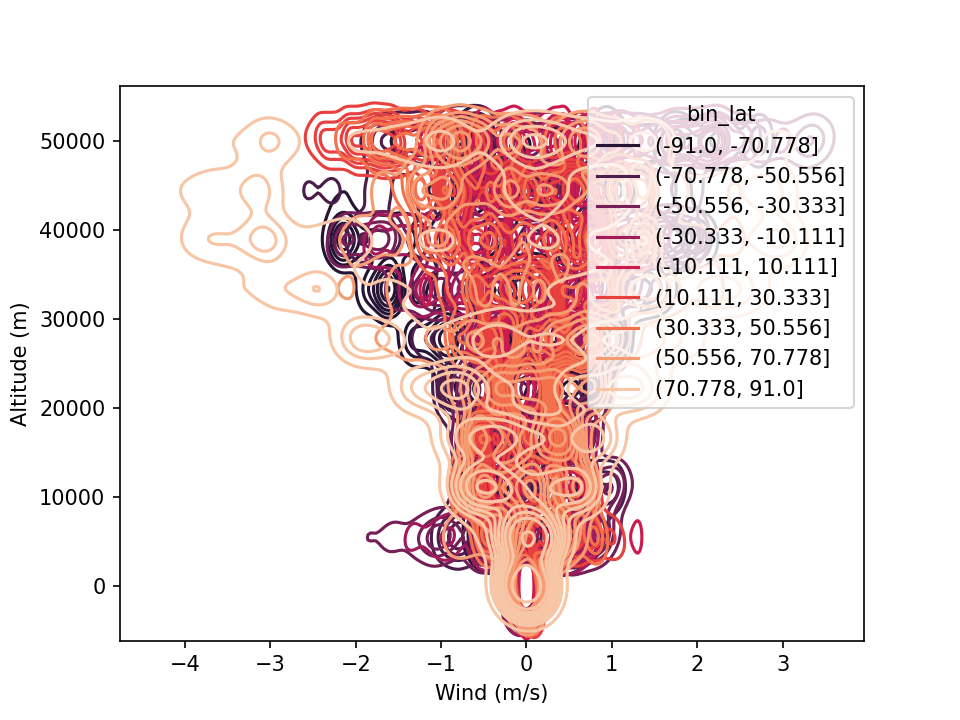

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0, 0.5, 'Altitude (m)')

In [13]:
plt.figure(); 
l_vars = ['W-E wind component (m/s)', 'S-N wind component (m/s)']
l_vars = ['S-N wind component (m/s)']
palettes = ['rocket', 'crest']
for palette, var in zip(palettes, l_vars):
    wind_data = all_data.loc[all_data['var'] == var]
    wind_data['bin_lat'] = pd.cut(all_data['lat'], bins=np.linspace(-91, 91, 10))
    sns.kdeplot(data=wind_data.sample(n=10000), x='val', y='alt', hue='bin_lat', palette=palette, bw_adjust=0.4)
    #plt.plot(atmos_JPL[var_JPL], atmos_JPL['z[m]'], color='blue', linewidth=3)
   
var_JPL = 'w_x[m/s]'
#plt.plot(atmos_JPL[var_JPL], atmos_JPL['z[m]'], color='blue', linewidth=3)
plt.xlabel('Wind (m/s)')
plt.ylabel('Altitude (m)')

## Save VCD data

In [ ]:
file_atmos = './test_data_Venus/VCD_atmos_globe.dat'
all_data.to_csv(file_atmos, header=True, index=False)

In [3]:
file_atmos = './data/VCD_atmos_globe.dat'
all_data = pd.read_csv(file_atmos)

In [6]:
all_data.alt.unique()

array([    0.        ,  5555.55555556, 11111.11111111, 16666.66666667,
       22222.22222222, 27777.77777778, 33333.33333333, 38888.88888889,
       44444.44444444, 50000.        ])

In [5]:
winds = all_data.loc[(all_data.alt==all_data.alt.unique()[-1])&(all_data['var'].isin(['W-E wind component (m/s)', 'S-N wind component (m/s)']))]
winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
winds['wind_direction'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.degrees(np.arctan2(-x.iloc[0], x.iloc[1])))
winds.sort_values(by=['lat', 'lon'], inplace=True)

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

## Simulate balloon trajectory

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

<IPython.core.display.Javascript object>


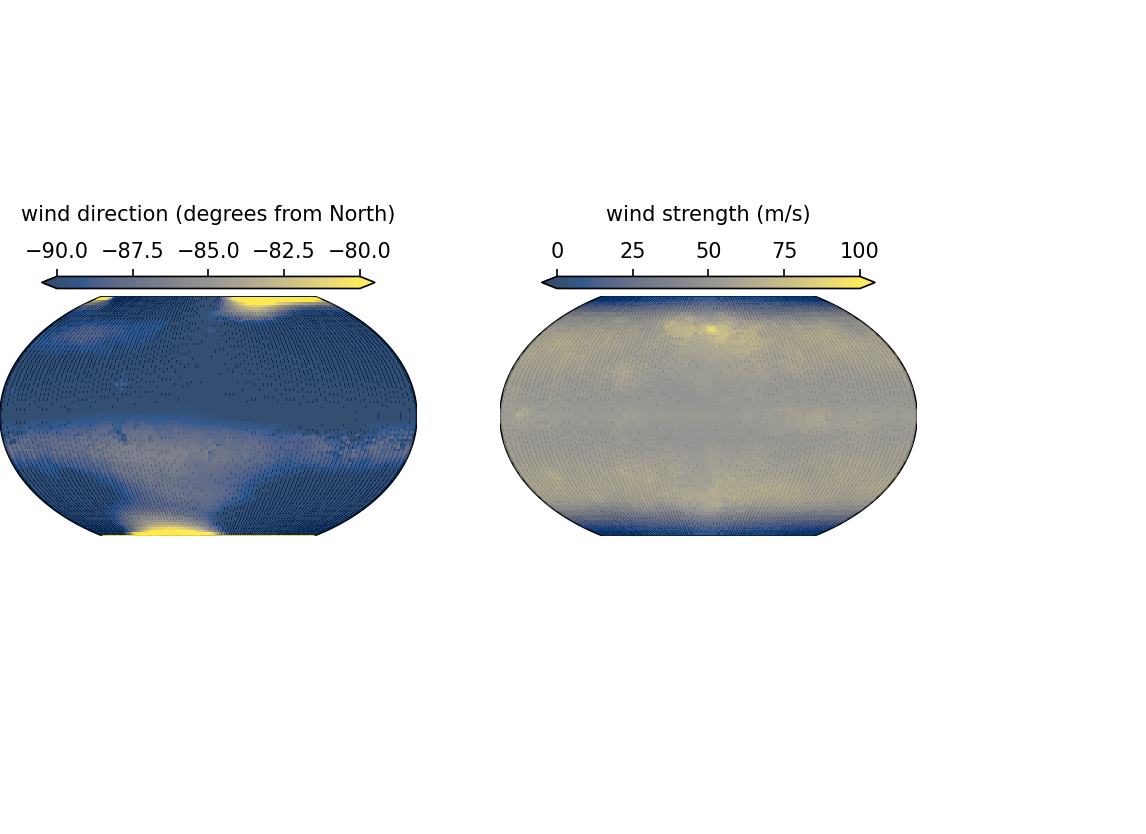

/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
/staff/quentin/miniconda2/envs/seismonpy/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.


In [71]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pyproj import Geod
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as clr
from matplotlib import patheffects
path_effects = [patheffects.withStroke(linewidth=3, foreground="w")]
    
def compute_distance(dist_top, dist_right, dist_bottom, dist_left, angle):
    # Convert the angle to radians
    angle_rad = np.radians(angle)

    # Compute the four possible intersection points
    x_right = dist_right
    y_right = dist_top + dist_right * np.tan(angle_rad)

    x_top = dist_left + dist_top / np.tan(angle_rad)
    y_top = dist_top

    x_left = dist_left
    y_left = dist_top - dist_left * np.tan(angle_rad)

    x_bottom = dist_left - dist_bottom / np.tan(angle_rad)
    y_bottom = dist_bottom

    # Check which intersection points are within the rectangle
    intersections = [(x_right, y_right) if 0 <= y_right <= dist_top else None,
                     (x_top, y_top) if 0 <= x_top <= dist_right else None,
                     (x_left, y_left) if 0 <= y_left <= dist_top else None,
                     (x_bottom, y_bottom) if 0 <= x_bottom <= dist_right else None]

    # Remove None values
    intersections = [point for point in intersections if point is not None]

    # Compute the distances to the intersection points
    distances = [np.sqrt(x**2 + y**2) for x, y in intersections]
    
    print(distances, intersections)

    iclosest = np.argmin(distances)
    # Return the minimum distance
    return distances[iclosest], intersections[iclosest]

def compute_trajectory(winds, start_location=[], nstep_max=1000, time_max=864000):
    
    g = Geod(ellps='WGS84') # Use Clarke 1866 ellipsoid.

    dlat, dlon = winds.lat.diff().max(), winds.lon.diff().max()
    if not start_location:
        start_location = [np.random.uniform(-90., 90., 1)[0], np.random.uniform(-180., 180., 1)[0]]
    locations = []
    times = []
    vels = []
    wind_dir = []
    #nstep_max = 1000
    #time_max = 10*24*3600

    istep = 0
    last_time = 0.
    while (last_time <= time_max) and (istep <= nstep_max):

        istep += 1
        dists = np.sqrt((winds.lat - start_location[0])**2+(winds.lon - start_location[1])**2)
        data = winds[dists==dists.min()]
        current_cell_location = data[['lat', 'lon']].iloc[0].values

        #windWE = data.loc[data['var'] == 'W-E wind component (m/s)', 'val'].iloc[0]
        #windSN = data.loc[data['var'] == 'S-N wind component (m/s)', 'val'].iloc[0]
        #wind_direction = np.degrees(np.arctan(windWE/windSN))
        #wind_strength = np.sqrt(windWE**2+windSN**2)
        wind_direction = data.wind_direction.iloc[0]
        wind_strength = data.wind_strength.iloc[0]
        vels.append( wind_strength )
        wind_dir.append( wind_direction )
        _, _, dist_to_edge_top = g.inv(start_location[1], start_location[0], current_cell_location[1], current_cell_location[0] + dlat/2.)
        _, _, dist_to_edge_bottom = g.inv(start_location[1], start_location[0], current_cell_location[1], current_cell_location[0] - dlat/2.)
        _, _, dist_to_edge_right = g.inv(start_location[1], start_location[0], current_cell_location[1] + dlon/2., current_cell_location[0])
        _, _, dist_to_edge_left = g.inv(start_location[1], start_location[0], current_cell_location[1] - dlon/2., current_cell_location[0])

        min_dist = min(dist_to_edge_top, dist_to_edge_right, dist_to_edge_bottom, dist_to_edge_left)/1e3
        max_dist = max(dist_to_edge_top, dist_to_edge_right, dist_to_edge_bottom, dist_to_edge_left)/1e3
        distances = np.linspace(min_dist, np.sqrt(2*(max_dist**2)))
        starts = np.repeat(start_location[1], distances.size)
        ends = np.repeat(start_location[0], distances.size)
        wind_directions = np.repeat(wind_direction, distances.size)
        lons, lats, _ = g.fwd(starts, ends, wind_directions, distances*1e3)

        points = []
        points.append( [current_cell_location[1], current_cell_location[0] + dlat/2.] )
        points.append( [current_cell_location[1], current_cell_location[0] - dlat/2.] )
        points.append( [current_cell_location[1] + dlon/2., current_cell_location[0]] )
        points.append( [current_cell_location[1] - dlon/2., current_cell_location[0]] )
        points = np.array(points)
        lons_pts = points[:,0]
        lats_pts = points[:,1]

        id_lons_pts = 0
        if (wind_direction>=45.)&(wind_direction<135.):
            id_lons_pts = 2
        elif (wind_direction>=135.)&(wind_direction<180.):
            id_lons_pts = 1
        else:
            id_lons_pts = 3
        iclosest = np.argmin(np.sqrt((lons_pts[id_lons_pts]-lons)**2 + (lats_pts[id_lons_pts]-lats)**2))

        start_location = [lats[iclosest], lons[iclosest]]

        locations.append( start_location )
        times.append( last_time + 1e3*distances[iclosest]/wind_strength )
        #vels.append( wind_strength )
        last_time = times[-1]

    """
    ## Not sure what that is
    dists = np.sqrt((winds.lat - start_location[0])**2+(winds.lon - start_location[1])**2)
    data = winds[dists==dists.min()]
    current_cell_location = data[['lat', 'lon']].iloc[0].values

    windWE = data.loc[data['var'] == 'W-E wind component (m/s)', 'val'].iloc[0]
    windSN = data.loc[data['var'] == 'S-N wind component (m/s)', 'val'].iloc[0]
    wind_direction = np.degrees(np.arctan(windWE/windSN))
    wind_strength = np.sqrt(windWE**2+windSN**2)
    vels.append( wind_strength )
    wind_dir.append( wind_direction )
    """
    
    locations = np.array(locations)
    times = np.array(times)
    wind_dir = np.array(wind_dir)
    #wind_strength = np.array(wind_strength)
    vels = np.array(vels)
    
    trajectory = pd.DataFrame()
    trajectory['time'] = times
    trajectory['lat'] = locations[:,0]
    trajectory['lon'] = locations[:,1]
    #trajectory['vel'] = vels
    trajectory['wind_dir'] = wind_dir
    trajectory['wind_strength'] = vels
    trajectory.reset_index(drop=True, inplace=True)
    
    return trajectory
    
def plot_one_map(ax, winds_grp, trajectory, unknown, display_legend=True, display_proba=False, display_final_proba=False, vmin=-180., vmax=180., unit='degrees from North'):
    
    m = Basemap(projection='kav7', resolution=None, lat_0=0, lon_0=0, ax=ax)
    
    lat_size = winds_grp.lat.unique().size
    lon_size = winds_grp.lon.unique().size
    
    LON, LAT = np.meshgrid(winds_grp.lon.unique(), winds_grp.lat.unique())
    x, y = m(LON.ravel(), LAT.ravel())
    x, y = x.reshape(lat_size, lon_size), y.reshape(lat_size, lon_size)
    #print(winds_grp.val.values.reshape(lat_size, lon_size))
    #print(x.shape, y.shape)
    #sc_dir = m.pcolormesh(x, y, winds_grp.val.values.reshape(lat_size, lon_size), cmap='cividis', alpha=0.8, zorder=5)
    sc_dir = m.pcolormesh(x, y, winds_grp[unknown].values.reshape(lat_size, lon_size), vmin=vmin, vmax=vmax, cmap='cividis', alpha=0.8, zorder=5)
    #x, y = m(winds_grp.lon.values, winds_grp.lat.values)
    #sc_dir = m.scatter(x, y, c=winds_grp[unknown], cmap='cividis', s=10, alpha=0.3, zorder=5)
    
    if trajectory.shape[0] > 0:
        x, y = m(trajectory.lon.values, trajectory.lat.values)
        if True:
            if display_proba:
                cmap = sns.color_palette('rocket', as_cmap=True)
                sc = m.scatter(x, y, c=trajectory.proba, cmap=cmap, s=5, zorder=10, vmin=0., vmax=1.)
            else:
                VariableLimits = np.arange(12)
                cmap = sns.color_palette('rocket', n_colors=VariableLimits.size, as_cmap=True)
                norm = clr.BoundaryNorm(VariableLimits, ncolors=256)
                sc = m.scatter(x, y, c=trajectory.time.values/(3600.*24), cmap=cmap, s=5, zorder=10, norm=norm)

            if display_legend:

                from matplotlib.ticker import FuncFormatter
                fmt = lambda x, pos: '{:.0%}'.format(x) # 
                axins = inset_axes(ax, width="3%", height="80%", loc='lower left', bbox_to_anchor=(1.03, 0.1, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
                axins.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
                cbar = plt.colorbar(sc, format=FuncFormatter(fmt), cax=axins, orientation='vertical', extend='both')

                if display_proba:
                    cbar.set_label('Probability', rotation=270, labelpad=10)
                else:
                    cbar.set_label('Time (days)', rotation=270, labelpad=10)

        if display_final_proba:
            m.scatter(x[-1], y[-1], edgecolor='red', facecolor=None, s=5, zorder=20)
            x, y = m(trajectory.lon.values[-1]+4., trajectory.lat.values[-1]-4.)
            ax.text(x, y, f'Final probability: {trajectory.proba.values[-1]*100:.0f}$\%$', zorder=50, path_effects=path_effects, ha='left', va='top', transform=ax.transData)
    
    
    axins_dir = inset_axes(ax, width="80%", height="5%", loc='lower left', bbox_to_anchor=(.1, 1.03, 1, 1.), bbox_transform=ax.transAxes, borderpad=0)
    axins_dir.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    cbar_dir = plt.colorbar(sc_dir, cax=axins_dir, orientation='horizontal', extend='both')
    cbar_dir.set_label(unknown.replace('_', ' ') + f' ({unit})', labelpad=10)
    cbar_dir.ax.xaxis.tick_top()
    cbar_dir.ax.xaxis.set_label_position('top')
    
def plot_trajectory(winds, trajectory, only_first_plot=True, vmin=-180., vmax=180.):
    
    winds_grp = winds.groupby(['lat', 'lon']).first().reset_index()
    
    fig = plt.figure(figsize=(6,5))
    if only_first_plot:
        grid = fig.add_gridspec(1, 1)
    else:
        grid = fig.add_gridspec(1, 2)
    
    ax = fig.add_subplot(grid[0,0])
    #winds_grp = winds.loc[winds['var'] == 'W-E wind component (m/s)']
    #plot_one_map(ax, winds_grp, 'val', display_days=False)
    plot_one_map(ax, winds_grp, trajectory, 'wind_direction', display_legend=True, display_proba=True, display_final_proba=True, vmin=vmin, vmax=vmax)
    #M0 = trajectory.M0.iloc[0]
    #ax.set_title(f'Detection probabilities for $M_w={M0:.1f}$', y=1.3)
    
    if not only_first_plot:

        ax = fig.add_subplot(grid[0,1])
        #winds_grp = winds.loc[winds['var'] == 'S-N wind component (m/s)']
        #plot_one_map(ax, winds_grp, 'val')
        plot_one_map(ax, winds_grp, trajectory, 'wind_strength', unit='m/s', vmin=0., vmax=100.)

    fig.subplots_adjust(left=0., right=0.8, bottom=0., top=1.,)
    #fig.savefig('./test_data_Venus/balloon_trajectory_proba2.png', transparent=True)

if True:
    winds = all_data.loc[(all_data.alt==all_data.alt.unique()[-1])&(all_data['var'].isin(['W-E wind component (m/s)', 'S-N wind component (m/s)']))]
    winds['gid'] = winds.groupby(['lat', 'lon'])['val'].transform('idxmin')
    winds['wind_strength'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.sqrt(sum(x**2)))
    winds['wind_direction'] = winds.groupby(['lat', 'lon'])['val'].transform(lambda x: np.degrees(np.arctan2(-x.iloc[0], x.iloc[1])))
    winds.sort_values(by=['lat', 'lon'], inplace=True)
    
if False:
    start_location=[50.,50.]
    trajectory = compute_trajectory(winds, start_location=start_location, nstep_max=1000, time_max=3600*24*15)
    trajectory.to_csv(f'./test_data_Venus/trajectory_balloon_lat{start_location[0]:.2f}_lon{start_location[1]:.2f}_15days.csv', header=True, index=False)
 
if True:
    M0s = trajectory.M0.unique()
    #plot_trajectory(winds, trajectory.loc[trajectory.M0==M0s[-2]], only_first_plot=True, vmin=-90., vmax=-80.)
    plot_trajectory(winds, trajectory.loc[trajectory.M0==-1], only_first_plot=False, vmin=-90., vmax=-80.)

## Visualize relaxation frequencies and strengths

In [ ]:
file_atmos = '../../EXAMPLES/validation_attenuation_zener/atmospheric_model_default.dat'
atmos = pd.read_csv(file_atmos, header=None, delim_whitespace=True)
atmos.columns = ['z', 'rho', 'c', 'p', 'g', 'kappa', 'mu', 'wx', 'cp', 'cv', 'gamma', 'taue', 'taus']
atmos['taus'] = 0.01
atmos['taue'] = 0.0105

taur = np.sqrt(atmos.taue.values*atmos.taus.values)
fr = 1./(2.*np.pi*taur)
Svib = (atmos.taue.values-atmos.taus.values)/taur

"""
plt.figure()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.scatter(atmos.z, fr)
ax.set_ylim([round(fr.min(), 2)-0.01, round(fr.min(), 2)+0.01])

plt.figure()
ax = plt.gca()
#ax.ticklabel_format(useOffset=False)
ax.scatter(atmos.z, Svib)
ax.set_ylim([round(Svib.min(), 2)-0.01, round(Svib.min(), 2)+0.01])
"""

file_atmos_out = '../../EXAMPLES/validation_attenuation_zener/atmospheric_model.dat'
atmos.to_csv(file_atmos_out, header=False, index=False, sep=' ')

In [ ]:
taue = np.linspace(0.1, 0.01, 1000)
taus = 0.01
taur = np.sqrt(taue*taus)
fr = 1./(2.*np.pi*taur)
Svib = (taue-taus)/taur

plt.figure()
ax = plt.gca()
ax.plot(taue, fr, color='tab:blue')
ax.set_ylabel('fr')
ax2 = ax.twinx()
ax2.plot(taue, Svib, color='tab:red')
ax2.set_ylabel('Svib')